In [1]:
%load_ext autoreload
%autoreload 2
from new_aeb_gplvm import *
import warnings
import json
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.distributions import kl_divergence

warnings.filterwarnings("ignore")
# import the necessary package
from tqdm import trange
from utils.data_generator import DataGenerator
from utils.myutils import Utils
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import trange

datagenerator = DataGenerator()  # data generator
utils = Utils()  # utils function

2023-12-10 22:11:47.800342: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 22:11:47.837061: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset_list = os.listdir("datasets/Classical")


def fix_name(name):
    fixed = name.replace(".npz", "")
    return fixed


datasets = list(map(fix_name, dataset_list))

In [3]:
df_hyper = pd.read_json("experiments/complete/gplvm/000_gplvm_normal_03_best.json")

In [4]:
def get_hypers(dataset):
    hypers = df_hyper[df_hyper.dataset == dataset]
    hp = hypers[
        [
            "kernel",
            "batch_size",
            "learning_rate",
            "latent_dim",
            "layers",
            "n_inducing",
            "n_epochs",
        ]
    ].to_dict(orient="records")
    return hp[0]

In [5]:
from baseline.PyOD import PYOD

model_dict = {"GPLVM": AD_GPLVM}

In [6]:
# datasets_ruins = [
#    "22_magic.gamma",
#    "33_skin",
# ]
# datasets_medianos = [
#    "41_Waveform",
#    "36_speech",
# ]
# datasets_bons = [
#    "16_http",
#    "21_Lymphography",
# ]
# datasets = datasets_ruins + datasets_medianos + datasets_bons

In [11]:
methods = ["blind"]
# labeled_anomalies = [0.01, 0.2, 0.4, 0.6, 0.8, 0.99]
tune_list = ["padrao"]

In [12]:
for dataset in [datasets[24],datasets[33]]:#datasets[24:25]:
    # for la in labeled_anomalies:
    for tune_type in tune_list:
        seed = 42
        # df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
        # df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())

        datagenerator.dataset = dataset  # specify the dataset name
        data = datagenerator.generator(
            la=1.00,
            realistic_synthetic_mode=None,
            noise_type=None,
            stdscale=True,
            minmax=False,
        )
        true_ratio = data["y_test"].sum() / len(data["y_test"])
        Y_train, Y_test, lb_train, lb_test = (
            data["X_train"],
            data["X_test"],
            data["y_train"],
            data["y_test"],
        )
        for method in methods:
            try:
                hp = get_hypers(dataset)
                aucroc = []
                aucpr = []
                for i in range(3):
                    clf = AD_GPLVM(
                        latent_dim=hp["latent_dim"],
                        n_inducing=hp["n_inducing"],
                        n_epochs=1000,  # hp["n_epochs"],
                        nn_layers=tuple(map(int, hp["layers"].split(","))),
                        lr=hp["learning_rate"],
                        batch_size=hp["batch_size"],
                        kernel=hp["kernel"],
                    )
                    clf.fit(Y_train, lb_train, loss_type=method, tune=tune_type)
                    score = clf.predict_score(Y_test)
                    result = utils.metric(y_true=lb_test, y_score=score)
                    aucroc.append(result["aucroc"])
                    aucpr.append(result["aucpr"])

                result["aucroc"] = np.mean(aucroc)
                result["aucpr"] = np.mean(aucpr)
            except Exception as e:
                print(f"problema no {dataset}")
                result["aucroc"] = 0.0
                result["aucpr"] = 0.0
            result["dataset"] = dataset
            result["method"] = method
            result["test_ratio"] = true_ratio
            result["train_ratio"] = true_ratio
            result["labeled_anomalies"] = 1.00
            result["loe_loss"] = clf.loe_list
            result["n_epochs"] = clf.i
            print(result["dataset"], print(result["aucroc"]))

            with open(
                f"experiments/complete/loe_x/{dataset}_{method}_{tune_type}_la_100.json",
                "w",
            ) as file:
                json.dump(result, file)

problema no 25_musk
0.0
25_musk None
subsampling for dataset 34_smtp...
0.043014338112704276
34_smtp None


In [38]:
# seed for reproducible results
dataset = datasets[24]
seed = 42
df_AUCROC = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
df_AUCPR = pd.DataFrame(data=None, index=datasets, columns=model_dict.keys())
# import the dataset
datagenerator.dataset = dataset  # specify the dataset name
data = datagenerator.generator(
    la=1.00,
    realistic_synthetic_mode=None,
    noise_type=None,
    stdscale=True,
    minmax=False,
)
ratio = data["y_train"].sum() / len(data["y_train"])
Y_train, Y_test, lb_train, lb_test = (
    data["X_train"],
    data["X_test"],
    data["y_train"],
    data["y_test"],
)
hp = get_hypers(dataset)
dataset

'25_musk'

In [39]:
# 15_Hepatitis, 18_Ionosphere, 20_letter

In [40]:
# skin fica bom para alternado/2, soft, 1000 epochs, 81%
#

In [41]:
clf = AD_GPLVM(
    latent_dim=hp["latent_dim"],
    n_inducing=hp["n_inducing"],
    n_epochs=1000,  # hp["n_epochs"],
    nn_layers=tuple(map(int, hp["layers"].split(","))),
    lr=hp["learning_rate"],
    batch_size=hp["batch_size"],
    kernel=hp["kernel"],
)

In [42]:
aucroc = []
for i in range(1):
    clf.fit(Y_train, lb_train, loss_type="hard", tune="start")
    score = clf.predict_score(Y_test)
    result = utils.metric(y_true=lb_test, y_score=score)
    aucroc.append(result["aucroc"])
print(np.mean(aucroc))

0.9996900426191399


In [43]:
result

{'aucroc': 0.9996900426191399, 'aucpr': 0.9895112454929957}

In [33]:
clf.i

999

In [34]:
# clf.lll.sum(), clf.klu.sum(), clf.klx.sum()

In [35]:
# elbo = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [36]:
# elbo(clf.pred, clf.batch)[0].sum(),elbo(clf.pred, clf.batch)[1].sum(), elbo(clf.pred, clf.batch)[3].sum()

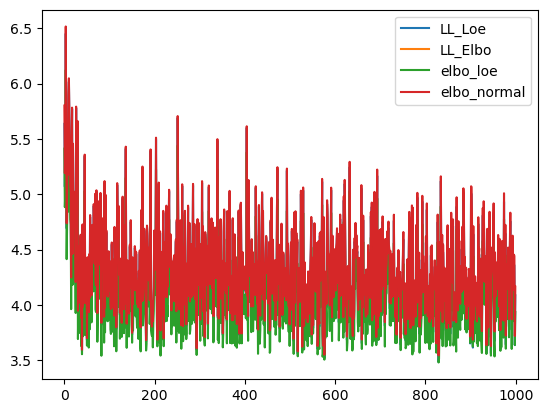

In [37]:
plt.plot(
    clf.lll_loe,
    label="LL_Loe",
)
plt.plot(
    clf.lll_elbo,
    label="LL_Elbo",
)
# plt.plot(
#    clf.klx_loe,
#    label="KLX_Loe",
# )
# plt.plot(
#    clf.klx_elbo,
#    label="KLX_Elbo",
# )
# plt.plot(
#    clf.klu_loe,
#    label="KLU_Loe",
# )
# plt.plot(
#    clf.klu_elbo,
#    label="KLU_Elbo",
# )
plt.plot(
    clf.loe_list,
    label="elbo_loe",
)
plt.plot(
    clf.loss_list,
    label="elbo_normal",
)
plt.legend()
None

In [20]:
clf.loe_list

[5.917835712432861,
 5.161812782287598,
 4.977456092834473,
 5.387106418609619,
 5.423708915710449,
 4.72867488861084,
 5.085492134094238,
 4.714599132537842,
 5.855776309967041,
 4.971911907196045,
 5.510462284088135,
 5.807730197906494,
 4.761587619781494,
 4.5644850730896,
 4.585537433624268,
 5.16880464553833,
 4.363542079925537,
 5.735939979553223,
 4.092412948608398,
 4.124083995819092,
 4.264488697052002,
 5.165974140167236,
 4.641584396362305,
 4.119235515594482,
 4.165712833404541,
 4.652310371398926,
 4.6877360343933105,
 4.911736488342285,
 3.8182737827301025,
 3.858912944793701,
 4.793105125427246,
 3.5873589515686035,
 4.2535719871521,
 4.2566914558410645,
 3.9845569133758545,
 4.108405590057373,
 3.9400930404663086,
 4.179274082183838,
 3.8598384857177734,
 4.488563537597656,
 5.364782810211182,
 4.172231674194336,
 4.5677971839904785,
 3.7288503646850586,
 4.150757312774658,
 3.9434032440185547,
 4.045762538909912,
 4.214837551116943,
 4.523081302642822,
 3.8020179271698

In [88]:
clf.elbo(clf.pred, clf.batch).sum()

tensor(-91.6781, grad_fn=<SumBackward0>)

In [132]:
kl_divergence(clf.encoder.kl_latent.q_x, clf.encoder.kl_latent.p_x).sum(axis=0) / (
    clf.encoder.kl_latent.n
)

tensor(0.1080, grad_fn=<DivBackward0>)

In [122]:
Y_train = torch.tensor(Y_train, dtype=torch.float32)
sample = clf.model.sample_latent_variable(Y_train)
output = clf.model(sample)

In [123]:
clf.elbo(output, Y_train.T).sum()

tensor(-42.5673, grad_fn=<SumBackward0>)

In [124]:
elbo_x = VariationalELBO(clf.likelihood, clf.model, len(Y_train), combine_terms=False)

In [125]:
ll, klu, _, klx = elbo_x(output, Y_train.T)
{
    "log_likelihood": ll,
    "ll_sum": ll.sum(),
    "klx": klx,
    "klx_sum": klx.sum(),
    "klu": klu,
    "klu_sum": klu.sum(),
    "total_sum": ll.sum() - klx.sum() - klu.sum(),
}

{'log_likelihood': tensor([-1.5695, -1.5708, -1.5703, -1.5700, -1.5688, -1.5696, -1.5694, -1.5694,
         -1.5697, -1.5705, -1.5697, -1.5696, -1.5700, -1.5695, -1.5694, -1.5696,
         -1.5691, -1.5698, -1.5701, -1.5699, -1.5698, -1.5706, -1.5703, -1.5698,
         -1.5695, -1.5698, -1.5698], grad_fn=<DivBackward0>),
 'll_sum': tensor(-42.3843, grad_fn=<SumBackward0>),
 'klx': tensor([0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
         0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040],
        grad_fn=<AddBackward0>),
 'klx_sum': tensor(0.1080, grad_fn=<SumBackward0>),
 'klu': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'kl

In [127]:
log_likelihood = (
    clf.likelihood.expected_log_prob(Y_train.T, output).sum(0).div(len(Y_train))
)
{
    "log_likelihood": log_likelihood,
    "log_likelihood_sum": log_likelihood.sum(),
}

{'log_likelihood': tensor([-0.0045, -0.0045, -0.0048,  ..., -0.0044, -0.0042, -0.0050],
        grad_fn=<DivBackward0>),
 'log_likelihood_sum': tensor(-42.3843, grad_fn=<SumBackward0>)}

In [128]:
klu_expanded = clf.model.variational_strategy.kl_divergence().div(len(Y_train))
{
    "klu_expanded": klu_expanded,
    "klu_expanded_sum": klu_expanded.sum(),
}

{'klu_expanded': tensor([0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0027, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028,
         0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028, 0.0028],
        grad_fn=<DivBackward0>),
 'klu_expanded_sum': tensor(0.0750, grad_fn=<SumBackward0>)}

In [45]:
klu_zero = torch.zeros_like(Y_train)
klu_zero

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
added_loss = torch.zeros_like(log_likelihood)
for added_loss_term in clf.model.added_loss_terms():
    added_loss.add_(added_loss_term.loss())
added_loss.sum()

tensor(26.7473, grad_fn=<SumBackward0>)

In [ ]:
contamination = lb_train.sum() / len(lb_train)